### Showcase FairCLIP Models

# 1. Dataset

The dataset is the Harvard-FairVLMed Dataset [[1]](#1) from Luo et al. (2024) [[2]](#2).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from IPython.display import display, Image

df = pd.read_csv('../data/Harvard-FairVLMed/data_summary.csv')

The dataset provides data on several features with characteristics relating to fairness, as well as ground truth data on glaucoma diagnosis and a summary of the clinical notes created using GPT-4. 

/tmp/ipykernel_18204/3614527785.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[cat_n//2, cat_n%2].text(i, counts[i], round(counts[i]/sum(counts)*100,1), ha = 'center', va = 'bottom')
/tmp/ipykernel_18204/3614527785.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[cat_n//2, cat_n%2].text(i, counts[i], round(counts[i]/sum(counts)*100,1), ha = 'center', va = 'bottom')
/tmp/ipykernel_18204/3614527785.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by

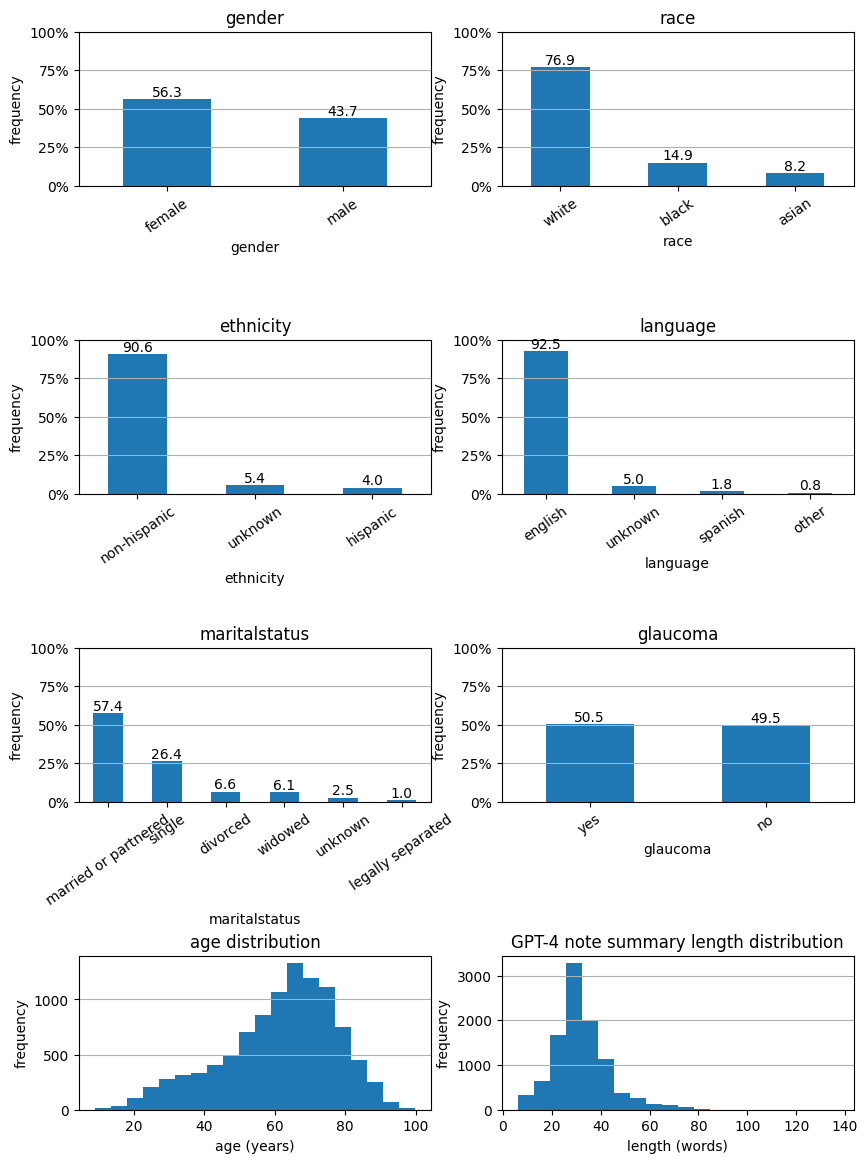

In [2]:
# bar plot glaucoma
l1 = ['gender', 'race', 'ethnicity', 'language', 'maritalstatus', 'glaucoma']
fig,ax = plt.subplots(nrows=4, ncols=2, figsize=(10,14)) 
fig.subplots_adjust(hspace=1)
for cat_n in range(len(l1)):
    counts = df[[l1[cat_n]]].value_counts()
    counts.plot(ax = ax[cat_n//2, cat_n%2], kind = 'bar', ylabel = 'frequency') 
    labels = [str(i[0]) for i in counts.index]
    ax[cat_n//2, cat_n%2].set_xticklabels(labels, rotation=35)
    ax[cat_n//2, cat_n%2].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(df)))
    ax[cat_n//2, cat_n%2].set_ylim(-1, 10000)
    ax[cat_n//2, cat_n%2].set_title(l1[cat_n])
    ax[cat_n//2, cat_n%2].grid(axis='y')
    # place value on top of bar
    for i in range(len(counts)):
        ax[cat_n//2, cat_n%2].text(i, counts[i], round(counts[i]/sum(counts)*100,1), ha = 'center', va = 'bottom')
df.age.plot(ax = ax[3,0], kind = 'hist', bins = 20, ylabel = 'frequency', title = 'age distribution')
ax[3,0].set_xlabel('age (years)')
ax[3, 0].grid(axis='y')
notes_length = df['gpt4_summary'].apply(lambda x: len(x.split()))
notes_length.plot(ax = ax[3,1], kind = 'hist', bins = 20, ylabel = 'frequency', title = 'GPT-4 note summary length distribution')
ax[3,1].set_xlabel('length (words)')
ax[3, 1].grid(axis='y')

fig.show() 


<Axes: title={'center': 'glaucoma'}, xlabel='gender,race,ethnicity,language', ylabel='frequency'>

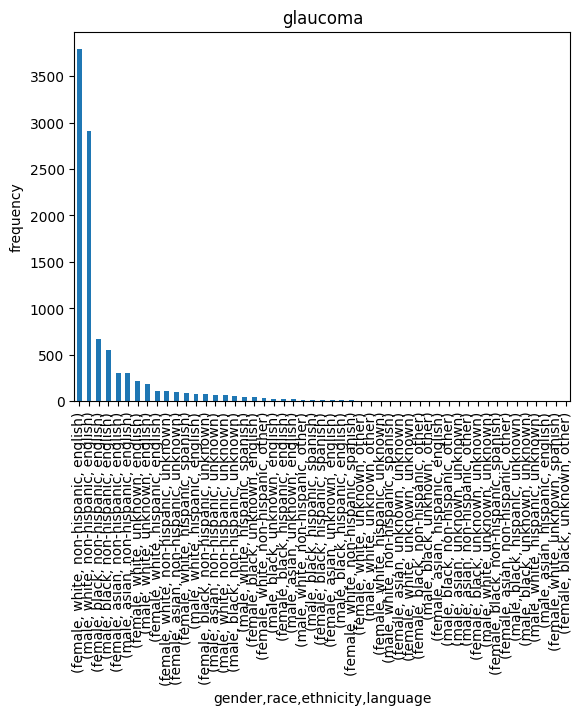

In [3]:
l1 = ['gender', 'race', 'ethnicity', 'language']

df[l1].value_counts().plot(kind = 'bar', ylabel = 'frequency', title = 'glaucoma')

The dataset also includes Ophthalmoscopy images, which are used by medical professionals to determine prescence of Glaucoma

/tmp/ipykernel_18204/3891656843.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


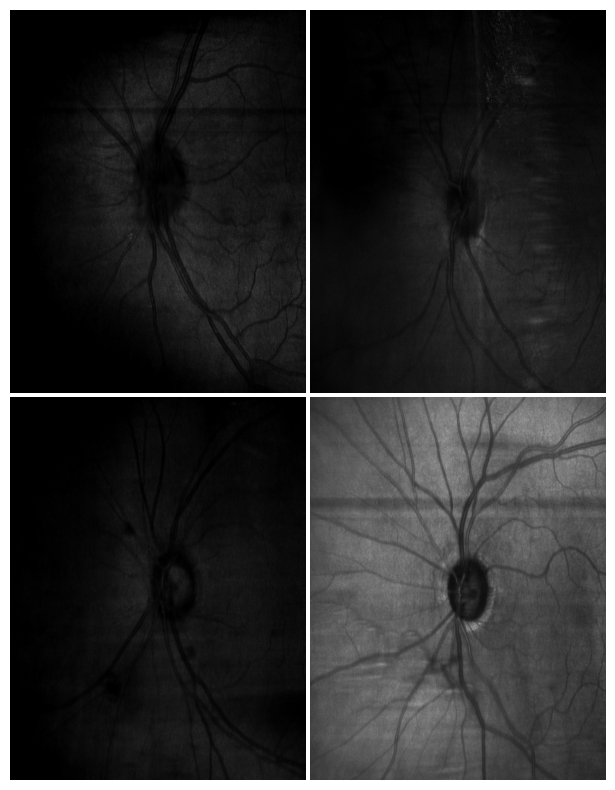

In [4]:
# display images in grid
fig, ax = plt.subplots(2, 2, figsize=(7.7,10))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
ax[0,0].imshow(plt.imread('../data/Harvard-FairVLMed/Training/slo_fundus_00001.jpg'))
ax[0,1].imshow(plt.imread('../data/Harvard-FairVLMed/Training/slo_fundus_00002.jpg'))
ax[1,0].imshow(plt.imread('../data/Harvard-FairVLMed/Training/slo_fundus_00003.jpg'))
ax[1,1].imshow(plt.imread('../data/Harvard-FairVLMed/Training/slo_fundus_00004.jpg'))

for i in range(2):
    for j in range(2):
        ax[i,j].axis('off')
fig.show()

## Models & Experiments
The models are based on 2 main architectures: CLIP and BLIP2, #TODO (Toevoegen of we BLIP2 ook Fair runnen), using the CLIP architecture a FairCLIP model is also generated. 

In [5]:
df_results = pd.read_csv('../results/best_vit-b16_slo_fundus.csv').loc[3:]
df_results.columns

Index(['epoch', ' acc', ' esacc_attr0', ' esacc_attr1', ' esacc_attr2',
       ' esacc_attr3', '  auc', ' esauc_attr0', ' esauc_attr1', ' esauc_attr2',
       ' esauc_attr3', '  auc_attr0_group0', ' auc_attr0_group1',
       ' auc_attr0_group2', ' auc_attr1_group0', ' auc_attr1_group1',
       ' auc_attr2_group0', ' auc_attr2_group1', ' auc_attr3_group0',
       ' auc_attr3_group1', ' auc_attr3_group2', '  dpd_attr0', ' dpd_attr1',
       ' dpd_attr2', ' dpd_attr3', '  eod_attr0', ' eod_attr1', ' eod_attr2',
       ' eod_attr3', '  std_group_disparity_attr0',
       ' max_group_disparity_attr0', ' std_group_disparity_attr1',
       ' max_group_disparity_attr1', ' std_group_disparity_attr2',
       ' max_group_disparity_attr2', ' std_group_disparity_attr3',
       ' max_group_disparity_attr3', '  path'],
      dtype='object')

In [33]:
def get_results(df_results):
    columns = df_results.columns
    # get columns containing esacc
    race_columns = [col for col in columns if 'attr0' in col]
    gender_columns = [col for col in columns if 'attr1' in col]
    ethnicity_columns = [col for col in columns if 'attr2' in col]
    language_columns = [col for col in columns if 'attr3' in col]

    df_results_race = df_results[race_columns].copy()
    df_results_gender = df_results[gender_columns].copy()
    df_results_ethnicity = df_results[ethnicity_columns].copy()
    df_results_language = df_results[language_columns].copy()

    grouped_params = [(race_columns, df_results_race, 'attr0', 'Race'), (gender_columns, df_results_gender, 'attr1', 'Gender'), (ethnicity_columns, df_results_ethnicity, 'attr2', 'Ethnicity'), (language_columns, df_results_language, 'attr3', 'Language')]

    # get mean and standard deviation for each column and add to df with appended name
    for (esacc_columns, partial_df, attr_idx, attr_name) in grouped_params:
        for col in esacc_columns:
            mean = partial_df[col].mean()*100
            std = partial_df[col].std()*100
            colname = col.replace('_' + attr_idx, '').strip()
            partial_df.loc[:, colname + '_mean'] = mean
            partial_df.loc[:, colname + '_std'] = std
            partial_df.drop(columns=[col], inplace=True)
        partial_df.insert(0, 'Attribute', attr_name)

        if "  auc" in df_results:
            partial_df.insert(0, 'auc_mean', df_results['  auc'].mean())
            partial_df.insert(0, 'auc_std', df_results['  auc'].std())
        else:
            partial_df.insert(0, 'auc_mean', df_results['auc'].mean())
            partial_df.insert(0, 'auc_std', df_results['auc'].std())
        partial_df.drop_duplicates(inplace=True)
        if attr_name == 'Race':
            df_results_final = partial_df.copy()
        else:
            df_results_final = pd.concat([df_results_final, partial_df], ignore_index=True)

    # add column Attribute with value Race
    df_results_final.fillna(' ', inplace=True)


    # reorder columns
    order = ['Attribute','dpd_mean', 'dpd_std', 'eod_mean', 'eod_std', 'auc_mean', 'auc_std', 'esauc_mean', 'esauc_std', 'auc_group0_mean', 'auc_group0_std', 'auc_group1_mean', 'auc_group1_std', 'auc_group2_mean', 'auc_group2_std']
    df_results_final = df_results_final[order]
    # round auc mean and std to 2 decimals
    df_results_final['auc_mean'] = df_results_final['auc_mean'].mean()*100
    df_results_final['auc_std'] = df_results_final['auc_std'].mean()*100

    return df_results_final

def print_results_latex(df_results_final):
    order = ['Attribute', 'dpd_mean', 'dpd_std', 'eod_mean', 'eod_std', 'auc_mean', 'auc_std', 'esauc_mean', 'esauc_std', 'auc_group0_mean', 'auc_group0_std', 'auc_group1_mean', 'auc_group1_std', 'auc_group2_mean', 'auc_group2_std']
    attributes = df_results_final['Attribute'].unique()
    attributes = list(attributes)
    n_models = len(df_results_final['Model'].unique())
    
    print(f"Order of attributes: {attributes}\n")
    
    for attribute in attributes:
        df_results_final_slice = df_results_final[df_results_final['Attribute'] == attribute]
        for x in range(n_models):
            # order the slice
            df_results_final_ordered_slice = df_results_final_slice[order]
            # print(df_results_final_ordered_slice)
            # store row 1 as list
            row1 = df_results_final_ordered_slice.iloc[x].values.tolist()
            results = []
            for i in range(len(row1)-1):
                if i % 2 == 0:
                    # if row1[i+1] is empty add empty string
                    if row1[i+1] == ' ':
                        results.append(' ')
                    # if row1[i+1] is highest value boldface
                    elif row1[i+1] == max(df_results_final_ordered_slice.iloc[:, i+1]) and df_results_final_ordered_slice.columns[i+1] not in ['dpd_mean', 'eod_mean']:
                        results.append('\\textbf{' + f"{row1[i+1]:.2f}" + '}' + ' $\pm$ ' + f"{row1[i+2]:.2f}")
                    elif row1[i+1] == min(df_results_final_ordered_slice.iloc[:, i+1]) and df_results_final_ordered_slice.columns[i+1] in ['dpd_mean', 'eod_mean']:
                        results.append('\\textbf{' + f"{row1[i+1]:.2f}" + '}' + ' $\pm$ ' + f"{row1[i+2]:.2f}")
                    # if second highest, underline
                    elif row1[i+1] == sorted(df_results_final_ordered_slice.iloc[:, i+1])[-2] and df_results_final_ordered_slice.columns[i+1] not in ['dpd_mean', 'eod_mean']:
                        results.append('\\underline{' + f"{row1[i+1]:.2f}"+ '}' + ' $\pm$ ' + f"{row1[i+2]:.2f}" )
                    elif row1[i+1] == sorted(df_results_final_ordered_slice.iloc[:, i+1])[1] and df_results_final_ordered_slice.columns[i+1] in ['dpd_mean', 'eod_mean']:
                        results.append('\\underline{' + f"{row1[i+1]:.2f}"+ '}' + ' $\pm$ ' + f"{row1[i+2]:.2f}" )
                    else:
                        results.append(f"{row1[i+1]:.2f}" + ' $\pm$ ' + f"{row1[i+2]:.2f}")
            # get model name idx x and attribute = Attribute, value model_name
            model_name = df_results_final_slice.iloc[x]['Model']
            print( ' & ' + model_name + ' & ' +' & '.join(results) + ' \\\\')
        print()


def create_full_table(csv_paths):
    df_results_final = None
    
    for path, model_name in csv_paths:
        df_output = pd.read_csv(path).loc[3:]
        df_results = get_results(df_output)
        # add model name to df
        df_results.insert(0, 'Model', model_name)

        if df_results_final is None:
            df_results_final = df_results.copy()
        else:
            df_results_final = pd.concat([df_results_final, df_results], ignore_index=True)
    return df_results_final


def create_full_table_singular(path, name_path_mapping):
    df_results_final = None
    df_output = pd.read_csv(path)

    for name, paths in name_path_mapping.items():
        df_results = get_results(df_output[df_output["path"].isin(paths)])
        df_results.insert(0, 'Model', name)

        if df_results_final is None:
            df_results_final = df_results.copy()
        else:
            df_results_final = pd.concat([df_results_final, df_results], ignore_index=True)
    
    return df_results_final


## FOR LINEAR PROBING
df_results_final = create_full_table_singular(
    path="../src/linear_probing_results_3.csv",
    name_path_mapping={
        "CLIP": [f"CLIP_{i}" for i in range(1, 4)],
        "CLIP-FT": ["CLIP_FT_seed1542", "CLIP_FT_seed2928", "CLIP_FT_seed9350"]
    }
)
display(df_results_final)
print_results_latex(df_results_final)


## FOR FINETUNING
# csv_paths = [
#     ['../results/best_vit-l14_slo_fundus.csv', 'Clip-ViT-L/14'], 
#     ['../results/best_vit-b16_slo_fundus_race_FairCLIP.csv', 'FairCLIP-Finetuned-Race'], 
#     ['../results/best_vit-l14_slo_fundus_gender_FairCLIP.csv', 'FairCLIP-Finetuned-Gender'], 
#     ['../results/best_vit-l14_slo_fundus_ethnicity_FairCLIP.csv','FairCLIP-Finetuned-Ethnicity'], 
#     ['../results/best_vit-l14_slo_fundus_language_FairCLIP.csv', 'FairCLIP-Finetuned-Language']
# ]
# df_results_final = create_full_table(csv_paths)
# print_results_latex(df_results_final)

# display(df_results_final)

/tmp/ipykernel_18204/183881171.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value ' ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_results_final.fillna(' ', inplace=True)
/tmp/ipykernel_18204/183881171.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value ' ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_results_final.fillna(' ', inplace=True)


,Model,Attribute,dpd_mean,dpd_std,eod_mean,eod_std,auc_mean,auc_std,esauc_mean,esauc_std,auc_group0_mean,auc_group0_std,auc_group1_mean,auc_group1_std,auc_group2_mean,auc_group2_std
0,CLIP,Race,8.141030,0.079855,8.389483,0.077497,72.925300,0.002541,68.020721,0.013635,75.913420,0.029992,69.020842,3.106706e-03,73.243146,0.000884
1,CLIP,Gender,1.244761,0.012167,5.447416,0.135528,72.925300,0.002541,68.175580,0.003032,69.763795,0.001189,76.730689,1.601989e-04,,
2,CLIP,Ethnicity,14.398683,0.727721,14.574315,0.062484,72.925300,0.002541,66.743841,0.001029,73.219801,0.002123,63.958333,0.000000e+00,,
3,CLIP,Language,18.603554,0.065348,15.512266,0.000000,72.925300,0.002541,70.909641,0.026018,72.665364,0.001923,71.022727,1.359740e-14,72.245227,0.039845
4,CLIP-FT,Race,6.734852,6.071845,13.466548,2.475941,75.676444,4.465616,71.531089,4.636398,78.617605,4.744512,73.523820,5.392699e+00,76.407848,4.690733
5,CLIP-FT,Gender,1.749166,0.195325,6.324251,0.812654,75.676444,4.465616,71.532949,3.501735,73.038577,3.924241,78.795362,5.020469e+00,,
6,CLIP-FT,Ethnicity,19.373004,3.334375,23.136123,3.110273,75.676444,4.465616,69.849974,4.796642,76.007507,4.395676,67.615741,5.490761e+00,,
7,CLIP-FT,Language,18.526737,5.089171,23.379314,10.896414,75.676444,4.465616,67.526037,6.190365,76.051249,4.517252,72.727273,1.238324e+01,69.00161,2.351093


Order of attributes: ['Race', 'Gender', 'Ethnicity', 'Language']

 & CLIP & \underline{8.14} $\pm$ 0.08 & \textbf{8.39} $\pm$ 0.08 & \underline{72.93} $\pm$ 0.00 & \underline{68.02} $\pm$ 0.01 & \underline{75.91} $\pm$ 0.03 & \underline{69.02} $\pm$ 0.00 & \underline{73.24} $\pm$ 0.00 \\
 & CLIP-FT & \textbf{6.73} $\pm$ 6.07 & \underline{13.47} $\pm$ 2.48 & \textbf{75.68} $\pm$ 4.47 & \textbf{71.53} $\pm$ 4.64 & \textbf{78.62} $\pm$ 4.74 & \textbf{73.52} $\pm$ 5.39 & \textbf{76.41} $\pm$ 4.69 \\

 & CLIP & \textbf{1.24} $\pm$ 0.01 & \textbf{5.45} $\pm$ 0.14 & \underline{72.93} $\pm$ 0.00 & \underline{68.18} $\pm$ 0.00 & \underline{69.76} $\pm$ 0.00 & \underline{76.73} $\pm$ 0.00 &   \\
 & CLIP-FT & \underline{1.75} $\pm$ 0.20 & \underline{6.32} $\pm$ 0.81 & \textbf{75.68} $\pm$ 4.47 & \textbf{71.53} $\pm$ 3.50 & \textbf{73.04} $\pm$ 3.92 & \textbf{78.80} $\pm$ 5.02 &   \\

 & CLIP & \textbf{14.40} $\pm$ 0.73 & \textbf{14.57} $\pm$ 0.06 & \underline{72.93} $\pm$ 0.00 & \underline{66.74}

In [8]:
csv_paths = [['../results/best_vit-b16_slo_fundus.csv', 'Clip-ViT-L/14'], ['../results/best_vit-b16_slo_fundus_race_FairCLIP.csv', 'FairCLIP-Finetuned-Race'], ['../results/best_vit-b16_slo_fundus_gender_FairCLIP.csv', 'FairCLIP-Finetuned-Gender'], ['../results/best_vit-b16_slo_fundus_ethnicity_FairCLIP.csv','FairCLIP-Finetuned-Ethnicity'], ['../results/best_vit-b16_slo_fundus_language_FairCLIP.csv', 'FairCLIP-Finetuned-Language']]

df_results_final = create_full_table(csv_paths)

print_results_latex(df_results_final)

display(df_results_final)


 & Clip-ViT-L/14 & 14.69 $\pm$ 7.96 & 17.47 $\pm$ 6.89 & \textbf{69.44} $\pm$ 1.66 & \textbf{64.89} $\pm$ 2.16 & \underline{73.32} $\pm$ 2.11 & \textbf{70.86} $\pm$ 2.16 & \textbf{68.10} $\pm$ 1.91 \\
 & FairCLIP-Finetuned-Race & 12.25 $\pm$ 6.16 & 13.85 $\pm$ 4.40 & 65.36 $\pm$ 2.40 & 60.04 $\pm$ 1.80 & 70.34 $\pm$ 3.67 & 66.09 $\pm$ 3.01 & 63.94 $\pm$ 2.90 \\
 & FairCLIP-Finetuned-Gender & \textbf{6.76} $\pm$ 8.37 & \underline{6.98} $\pm$ 8.03 & 66.88 $\pm$ 2.09 & 62.68 $\pm$ 0.78 & 69.33 $\pm$ 5.07 & 69.13 $\pm$ 2.24 & 65.46 $\pm$ 1.96 \\
 & FairCLIP-Finetuned-Ethnicity & \underline{2.69} $\pm$ 3.65 & \textbf{9.03} $\pm$ 5.64 & \underline{68.27} $\pm$ 2.62 & \underline{63.69} $\pm$ 3.27 & \textbf{73.44} $\pm$ 2.85 & 69.07 $\pm$ 1.71 & \underline{67.05} $\pm$ 3.19 \\
 & FairCLIP-Finetuned-Language & 13.36 $\pm$ 9.81 & 13.80 $\pm$ 10.68 & 67.23 $\pm$ 3.10 & 62.43 $\pm$ 2.28 & 70.88 $\pm$ 3.48 & \underline{69.81} $\pm$ 5.01 & 65.78 $\pm$ 3.05 \\

 & Clip-ViT-L/14 & \underline{3.16} $\p

,Model,Attribute,dpd_mean,dpd_std,eod_mean,eod_std,auc_mean,auc_std,esauc_mean,esauc_std,auc_group0_mean,auc_group0_std,auc_group1_mean,auc_group1_std,auc_group2_mean,auc_group2_std
0,Clip-ViT-L/14,Race,14.69,7.96,17.47,6.89,69.44,1.66,64.89,2.16,73.32,2.11,70.86,2.16,68.10,1.91
1,Clip-ViT-L/14,Gender,3.16,2.23,8.25,3.87,69.44,1.66,64.65,1.44,66.20,1.56,73.60,1.95,,
2,Clip-ViT-L/14,Ethnicity,9.43,3.60,11.96,5.41,69.44,1.66,63.52,1.26,69.73,1.66,60.43,1.23,,
3,Clip-ViT-L/14,Language,12.42,4.09,21.47,7.36,69.44,1.66,60.75,0.62,69.59,1.65,65.62,5.97,60.48,3.23
4,FairCLIP-Finetuned-Race,Race,12.25,6.16,13.85,4.40,65.36,2.40,60.04,1.80,70.34,3.67,66.09,3.01,63.94,2.90
5,FairCLIP-Finetuned-Race,Gender,3.83,2.71,6.78,4.88,65.36,2.40,61.33,2.42,62.50,2.49,69.09,2.32,,
6,FairCLIP-Finetuned-Race,Ethnicity,8.77,3.57,14.49,4.82,65.36,2.40,59.44,1.01,65.74,2.49,55.81,0.85,,
7,FairCLIP-Finetuned-Race,Language,7.26,4.79,16.52,12.07,65.36,2.40,54.83,2.93,65.53,2.54,52.75,2.86,58.79,4.16
8,FairCLIP-Finetuned-Gender,Race,6.76,8.37,6.98,8.03,66.88,2.09,62.68,0.78,69.33,5.07,69.13,2.24,65.46,1.96
9,FairCLIP-Finetuned-Gender,Gender,1.79,2.87,3.79,5.85,66.88,2.09,62.80,1.74,64.06,1.90,70.56,2.47,,


In [7]:
\begin{table*}[ht]
\centering
\scriptsize
\caption{Zero-shot transfer results of CLIP vs. FairCLIP, reporting the mean and standard deviation across three random seeds.
% We report the mean and standard deviation across three random seeds for all experiments. The scores are in persentage.
}
\vspace{-2ex}
\label{tab:zero_shot_clip}
\adjustbox{width=.5\textwidth}{
\begin{tabular}{llccc}
\toprule
\textbf{Attribute} & \textbf{Model}  & \multicolumn{3}{c}{\textbf{Group-wise AUC $\uparrow$}} \\ \midrule
&&\textbf{Asian} & \textbf{Black} & \textbf{White} \\
\multirow{4}{*}{\textbf{Race}} 
 & CLIP-ViT-L/14 & 64.6 $\pm$ 6.64 & 65.74 $\pm$ 8.25 & 62.93 $\pm$ 5.65 \\
 & FairCLIP-Race & \underline{69.88} $\pm$ 2.2 & \underline{69.31} $\pm$ 1.53 & \underline{66.13} $\pm$ 2.3 \\
 & FairCLIP-Gender & 69.07 $\pm$ 2.8 & \textbf{69.87} $\pm$ 2.95 & 64.32 $\pm$ 2.08 \\
 & FairCLIP-Ethnicity & 63.57 $\pm$ 2.0 & 66.99 $\pm$ 6.09 & 61.61 $\pm$ 1.23 \\
 & FairCLIP-Language &\textbf{ 73.08} $\pm$ 6.24 & 69.02 $\pm$ 3.52 & \textbf{67.19 }$\pm$ 4.7 \\                       \midrule
&&\textbf{Female} & \textbf{Male} \\
\multirow{4}{*}{\textbf{Gender}} 
 & CLIP-ViT-L/14 & 61.61 $\pm$ 5.24 & 67.69 $\pm$ 7.11 &   \\
 & FairCLIP-Race & \underline{64.35} $\pm$ 1.9 & \underline{71.32} $\pm$ 1.83 &      \\
 & FairCLIP-Gender & 63.39 $\pm$ 2.26 & 70.15 $\pm$ 2.01 &      \\
 & FairCLIP-Ethnicity & 61.13 $\pm$ 1.52 & 66.28 $\pm$ 3.81 &     \\
 & FairCLIP-Language &\textbf{ 66.08} $\pm$ 4.44 & \textbf{71.62} $\pm$ 3.69 &    \\
                               \midrule
&&\textbf{Non-Hispanic} & \textbf{Hispanic} \\
\multirow{4}{*}{\textbf{Ethnicity}} 
 & CLIP-ViT-L/14 & 64.48 $\pm$ 6.14 & 56.24 $\pm$ 3.04 &    \\
 & FairCLIP-Race & \underline{67.66} $\pm$ 1.97 & \underline{58.91} $\pm$ 2.66 &     \\
 & FairCLIP-Gender & 66.54 $\pm$ 2.17 & 57.94 $\pm$ 0.74 &      \\
 & FairCLIP-Ethnicity & 63.63 $\pm$ 2.3 & 53.88 $\pm$ 4.68 &      \\
  & FairCLIP-Language & \textbf{68.62} $\pm$ 4.1 & \textbf{63.01} $\pm$ 4.75 &     \\
                                \midrule
&&\textbf{English} & \textbf{Spanish} & \textbf{Others} \\
\multirow{4}{*}{\textbf{Language}} 
 & CLIP-ViT-L/14 & 63.97 $\pm$ 6.25 & \textbf{68.37} $\pm$ 3.13 & 61.13 $\pm$ 2.87 \\
 & FairCLIP-Race & \underline{67.23} $\pm$ 1.95 & 62.88 $\pm$ 3.27 & \textbf{63.57} $\pm$ 3.6 \\
 & FairCLIP-Gender & 66.14 $\pm$ 2.14 & \underline{64.77} $\pm$ 0.49 & 60.98 $\pm$ 2.58 \\
 & FairCLIP-Ethnicity & 63.26 $\pm$ 2.2 & 56.91 $\pm$ 14.44 & 56.51 $\pm$ 2.45 \\
& FairCLIP-Language & \textbf{68.43} $\pm$ 4.16 & \textbf{68.37} $\pm$ 7.99 & \underline{62.58} $\pm$ 6.21 \\
\bottomrule
\end{tabular}}
\end{table*}

SyntaxError: unexpected character after line continuation character (2441733528.py, line 1)

## References
<a id="1">[1]</a> 
https://ophai.hms.harvard.edu/datasets/harvard-fairvlmed10k

<a id="2">[2]</a> 
Luo, Y., Shi, M., Khan, M. O., Afzal, M. M., Huang, H., Yuan, S., ... & Wang, M. (2024). Fairclip: Harnessing fairness in vision-language learning. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 12289-12301).